In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_a', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_c'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9274655604072799
RMSE:  0.23637947894945588
RMSE unscaled:  0.008883359393194087
----------------------------------------


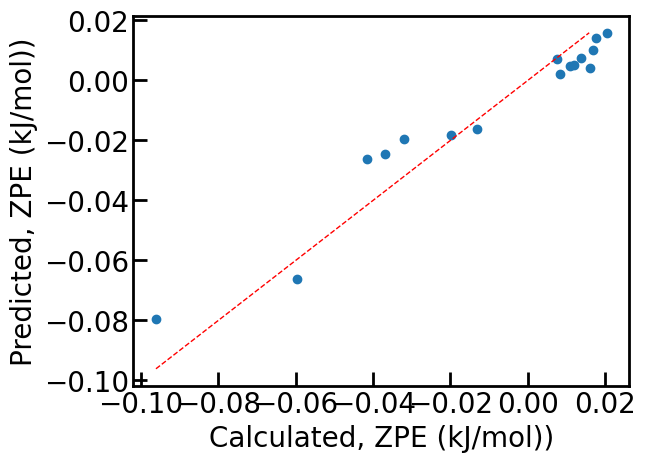

GB 0.8994907621167645
RMSE:  0.2782534969071118
RMSE unscaled:  0.010457023707914324
----------------------------------------


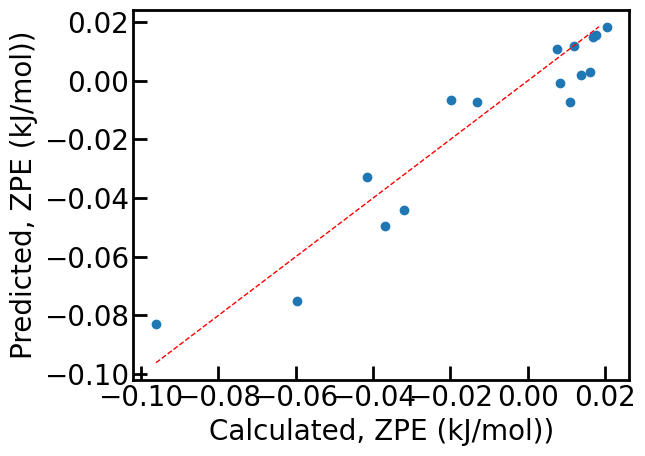

RR 0.9680483701188284
RMSE:  0.15688598523406888
RMSE unscaled:  0.005895920393697032
----------------------------------------


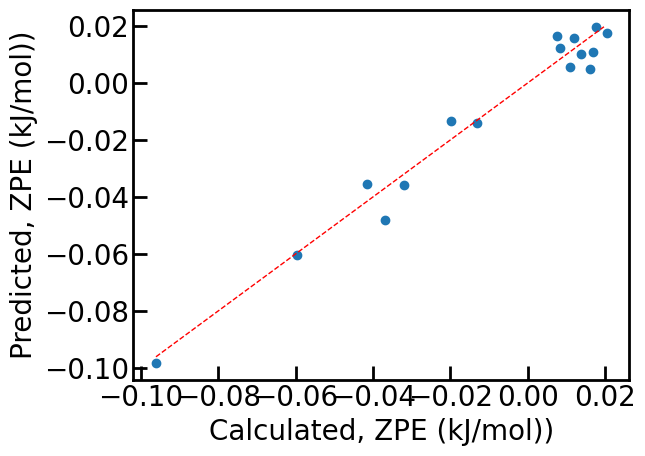

LASSO 0.943546109613657
RMSE:  0.20853769976710884
RMSE unscaled:  0.00783703958691504
----------------------------------------


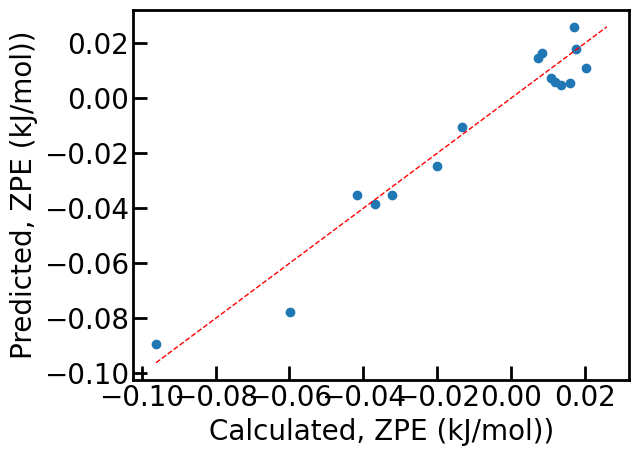

gpr1 0.9721776737079965
RMSE:  0.14639773608788031
RMSE unscaled:  0.0055017622925579894
----------------------------------------


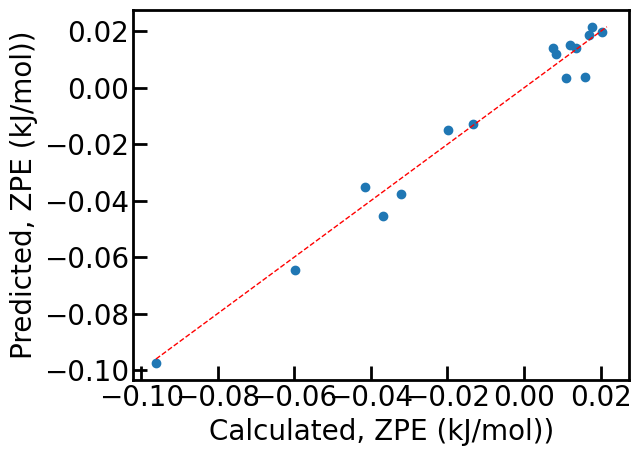

gpr2 0.9705042409688668
RMSE:  0.15073615370452492
RMSE unscaled:  0.005664804038219249
----------------------------------------


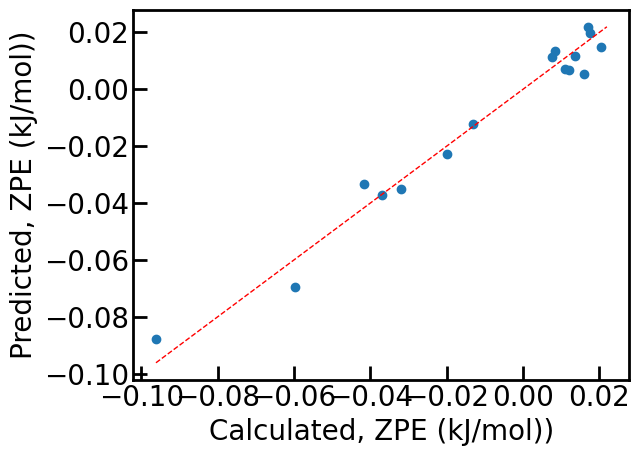

gpr3 0.9771170142430924
RMSE:  0.13276817516818648
RMSE unscaled:  0.004989550790277105
----------------------------------------


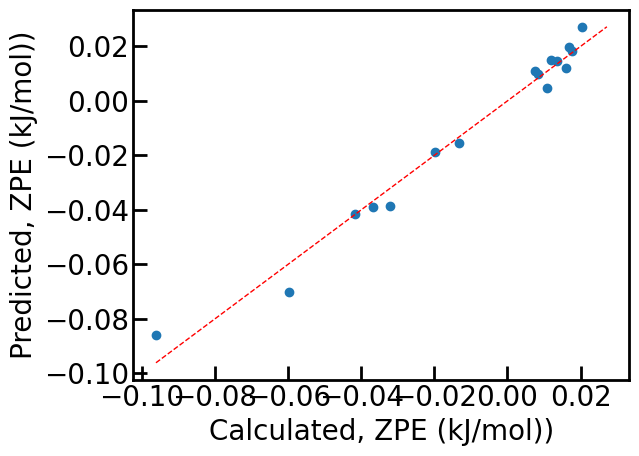

gpr4 0.9840239057563723
RMSE:  0.11093611376006808
RMSE unscaled:  0.004169081734991352
----------------------------------------


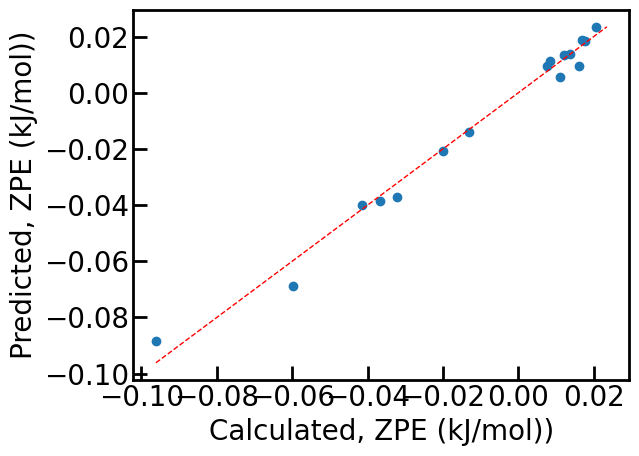

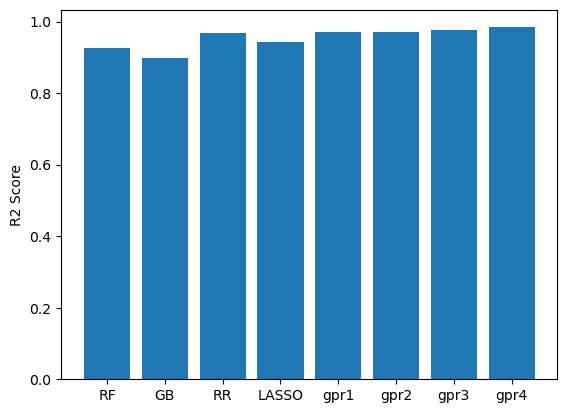

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  277.737710
2        s_X  224.504930
17       X_Z  180.497379
35      X_Ra  129.086980
7   mean_X2X  118.159584
5   mean_A2X   74.465968
1        s_B   40.154500
28      X_EA   37.557853
33    A_Rvdw   32.584372
12     E_coh   32.515523
32    X_ChiA   30.555031
45   X_Kappa   29.271831
0        s_A   25.107221
44   B_Kappa   24.034137
20     A_IEI   19.266747
22     X_IEI   15.954796
27      B_EA   15.195064
41      X_MV   14.461649
9    std_A2X   11.506073
31    A_ChiA   10.073841
15       A_Z    9.312288
29    A_ChiP    8.660578
37      A_BP    7.927719
25    X_IEII    7.574441
43   A_Kappa    7.450991
10   std_B2X    7.056630
16       B_Z    6.873299
30    B_ChiP    6.817450
39     B_Rho    5.873219
36      B_MP    5.617228


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA', 'A_Z',
       'A_ChiP', 'A_BP', 'X_IEII', 'A_Kappa', 'std_B2X', 'B_Z', 'B_ChiP',
       'B_Rho', 'B_MP', 'A_CvM', 'B_IEI', 'A_EA', 'B_Hf', 'density',
       'A_B', 'TF', 'OF', 'A_G', 'B_MV'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9155271430063949
RMSE:  0.255091643838816
RMSE unscaled:  0.009586579852413554
----------------------------------------


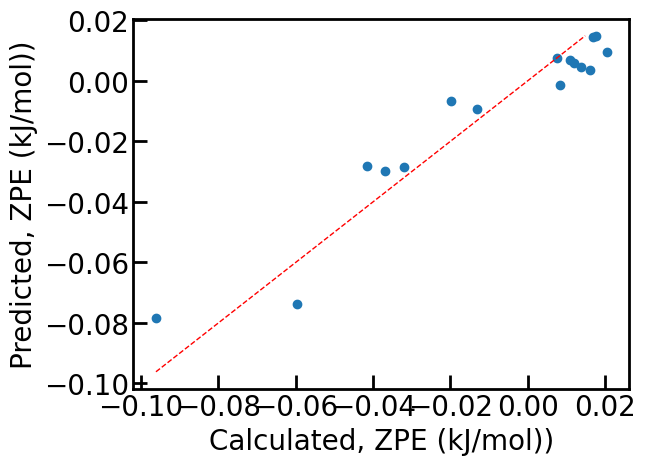

GB 0.8551964800106784
RMSE:  0.33398518336476457
RMSE unscaled:  0.012551472018708676
----------------------------------------


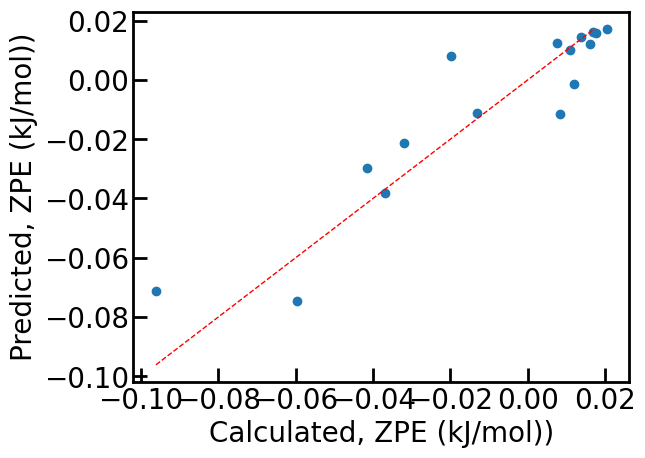

RR 0.9768581626523434
RMSE:  0.13351699809813694
RMSE unscaled:  0.0050176922484027366
----------------------------------------


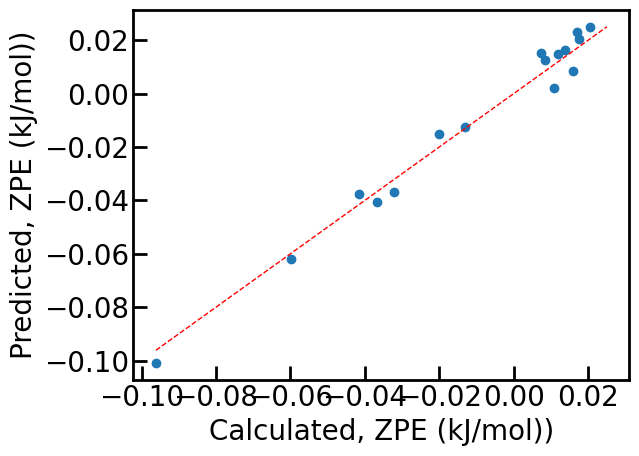

LASSO 0.9449665181639858
RMSE:  0.20589752975471537
RMSE unscaled:  0.007737819556549204
----------------------------------------


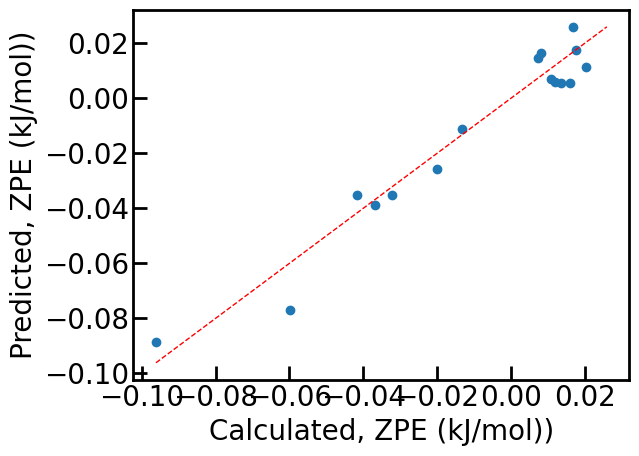

gpr1 0.9805510501318627
RMSE:  0.12240121236203645
RMSE unscaled:  0.004599950741947197
----------------------------------------


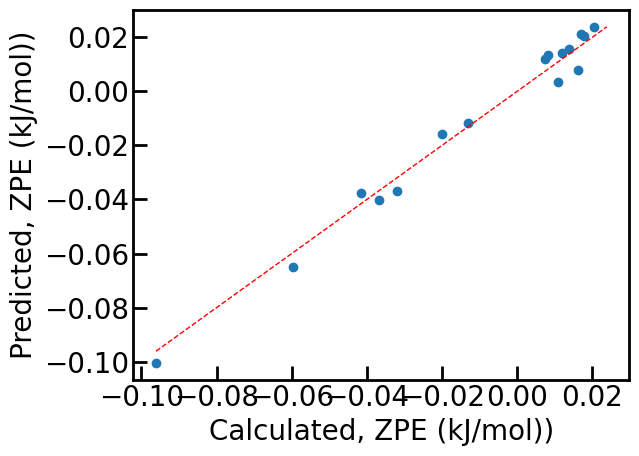

gpr2 0.9725179862934422
RMSE:  0.14549963938431174
RMSE unscaled:  0.005468010987990013
----------------------------------------


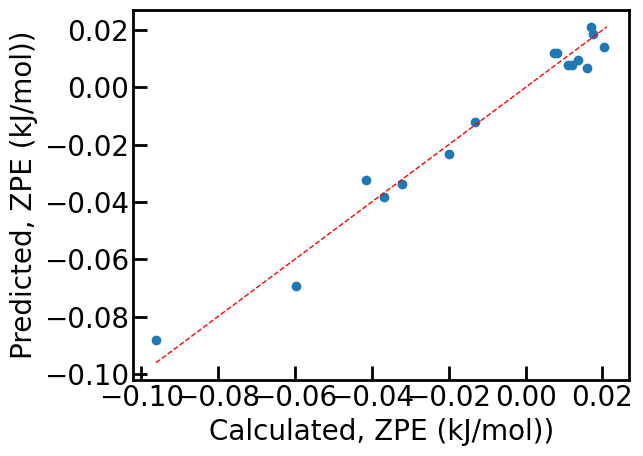

gpr3 0.9714151039868559
RMSE:  0.14839044914050764
RMSE unscaled:  0.005576650291688329
----------------------------------------


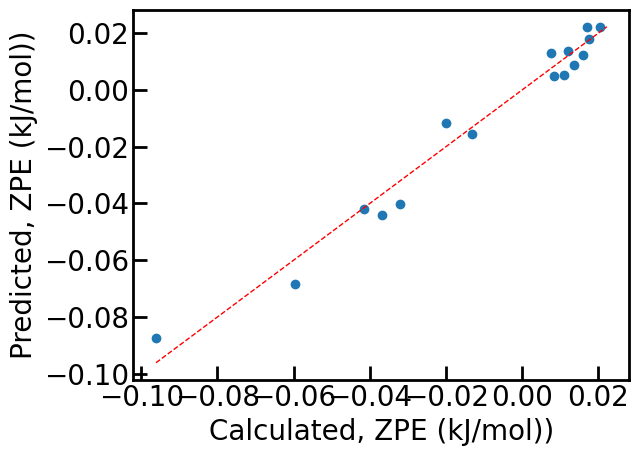

gpr4 0.9833337045536974
RMSE:  0.11330711432277743
RMSE unscaled:  0.004258186128543705
----------------------------------------


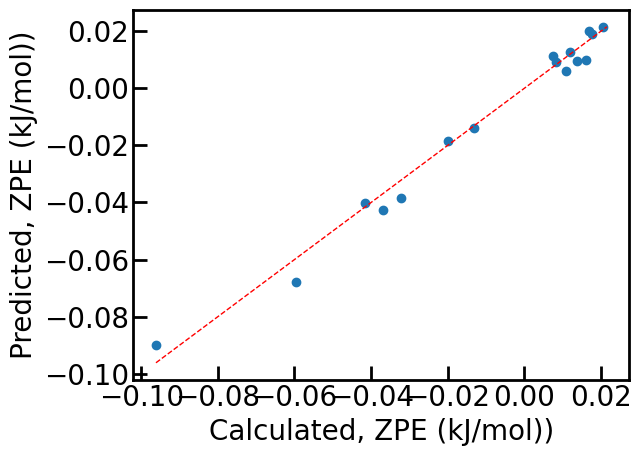

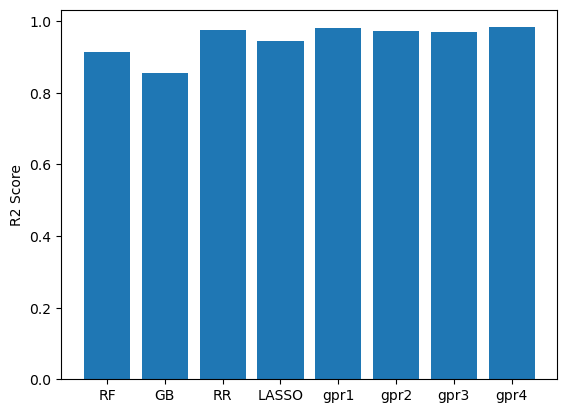

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA', 'A_Z',
       'A_ChiP', 'A_BP', 'X_IEII', 'A_Kappa', 'std_B2X', 'B_Z', 'B_ChiP',
       'B_Rho', 'B_MP'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9245407671047545
RMSE:  0.24109812558023536
RMSE unscaled:  0.00906069049679493
----------------------------------------


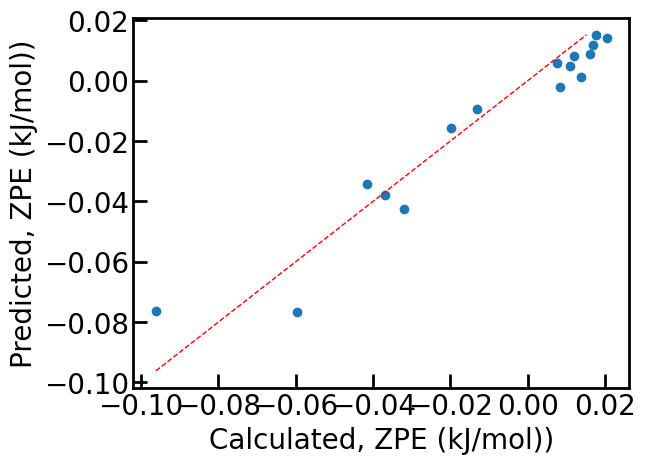

GB 0.946443757768866
RMSE:  0.20311532384819891
RMSE unscaled:  0.007633261685945141
----------------------------------------


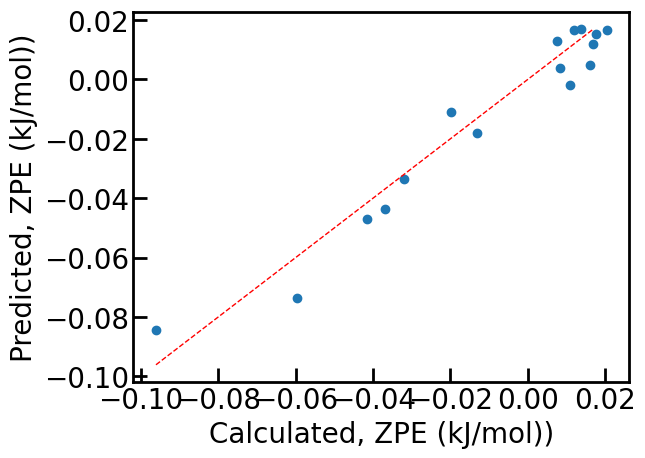

RR 0.9860865672735987
RMSE:  0.10352727604617161
RMSE unscaled:  0.003890650762933639
----------------------------------------


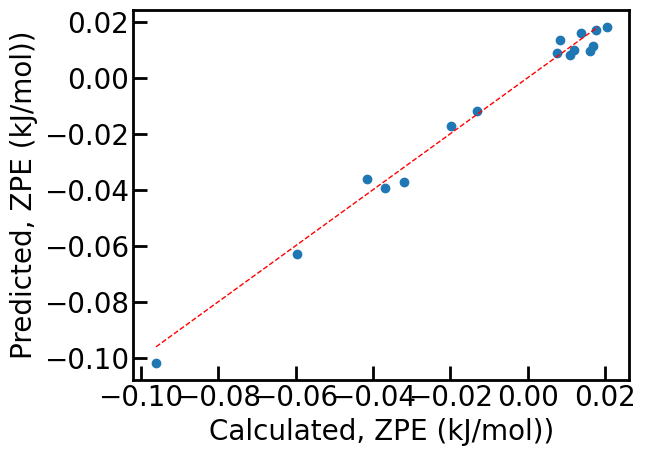

LASSO 0.9506072437729469
RMSE:  0.19506047242792846
RMSE unscaled:  0.007330552921448954
----------------------------------------


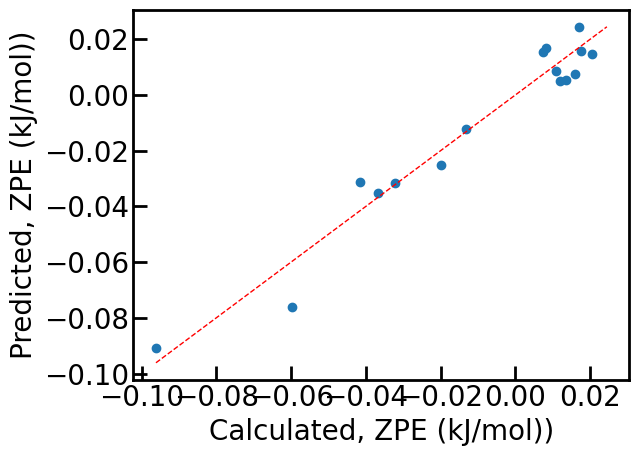

gpr1 0.9868462054983121
RMSE:  0.10066144660576325
RMSE unscaled:  0.003782950242601299
----------------------------------------


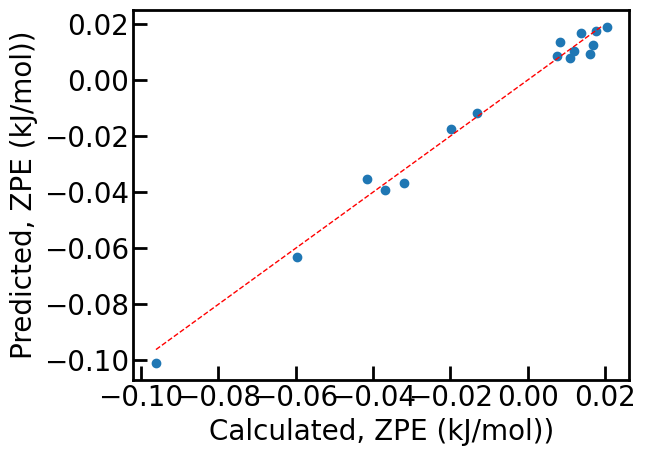

gpr2 0.9758295743740333
RMSE:  0.13645196370536214
RMSE unscaled:  0.005127990969812562
----------------------------------------


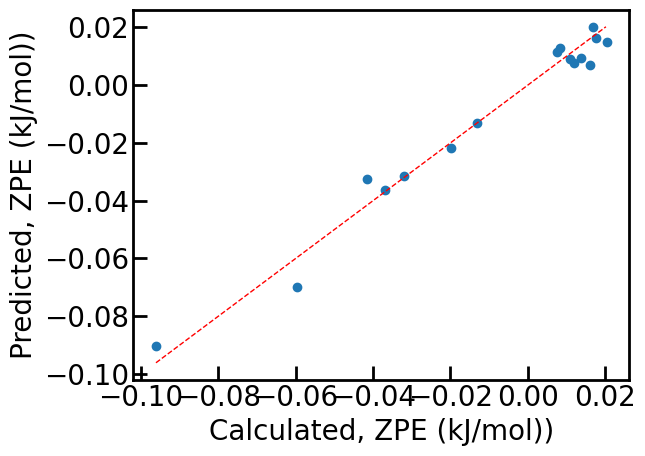

gpr3 0.9635606272768931
RMSE:  0.16754176533397597
RMSE unscaled:  0.006296374462988558
----------------------------------------


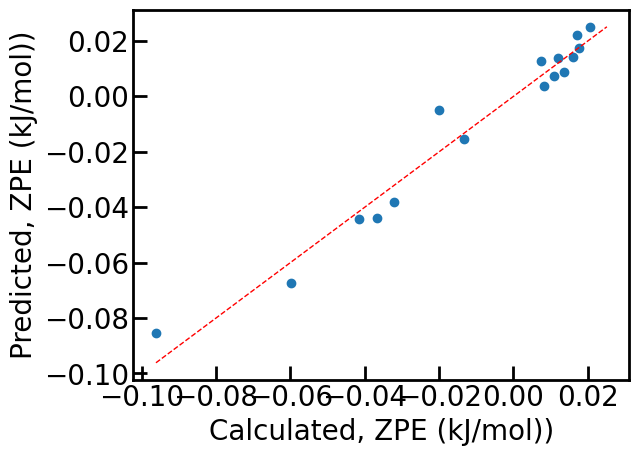

gpr4 0.9842561437595758
RMSE:  0.11012684534313816
RMSE unscaled:  0.00413866867957258
----------------------------------------


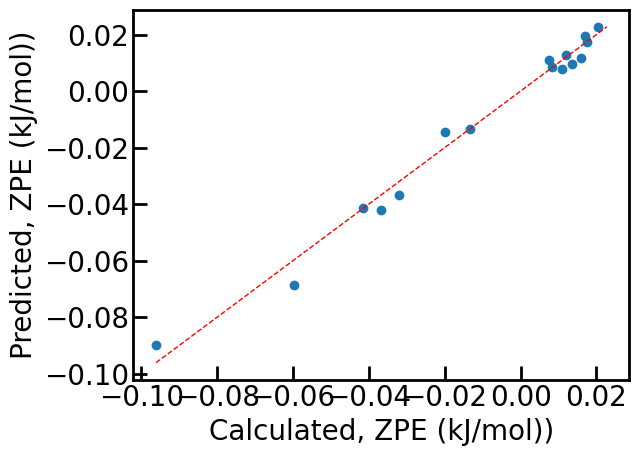

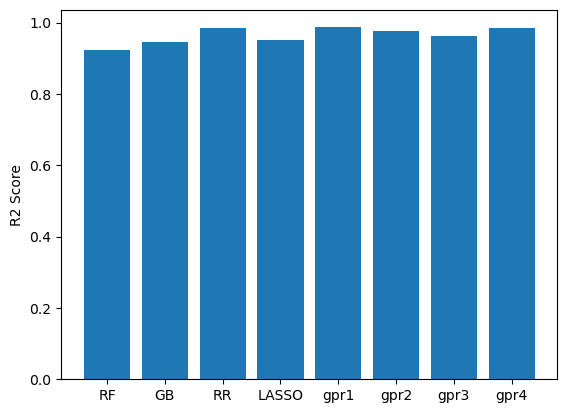

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA'],
      dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9073328667364056
RMSE:  0.2671778833749256
RMSE unscaled:  0.010040791910028126
----------------------------------------


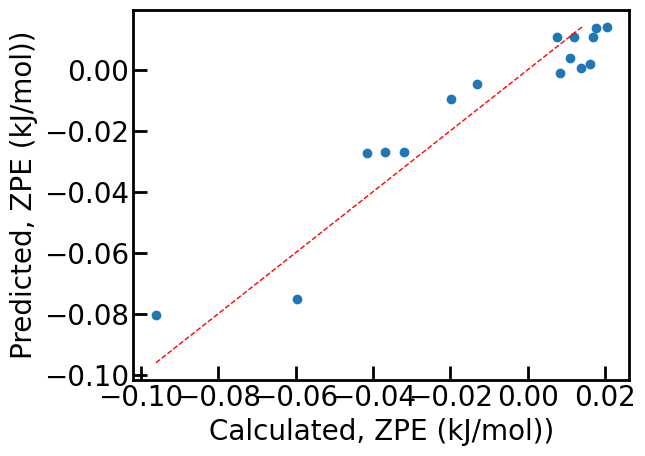

GB 0.8985842372357147
RMSE:  0.2795055086993624
RMSE unscaled:  0.010504075468771521
----------------------------------------


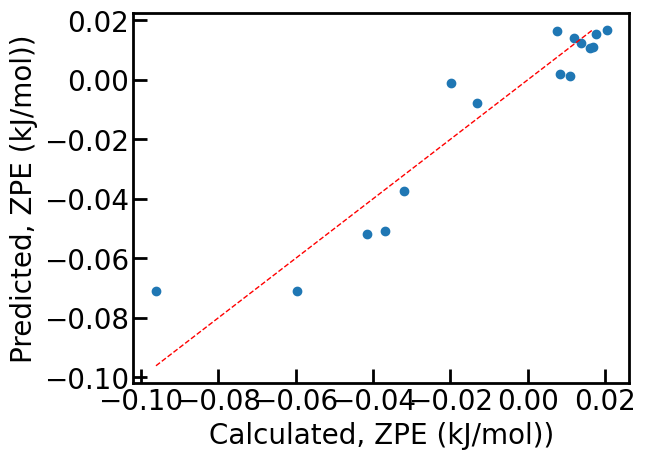

RR 0.9443427927476022
RMSE:  0.20706101870452204
RMSE unscaled:  0.007781544547132471
----------------------------------------


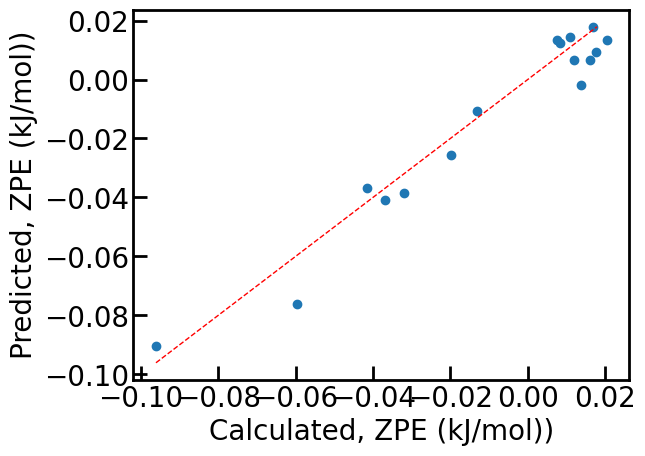

LASSO 0.91516485199384
RMSE:  0.2556380828617084
RMSE unscaled:  0.009607115536172536
----------------------------------------


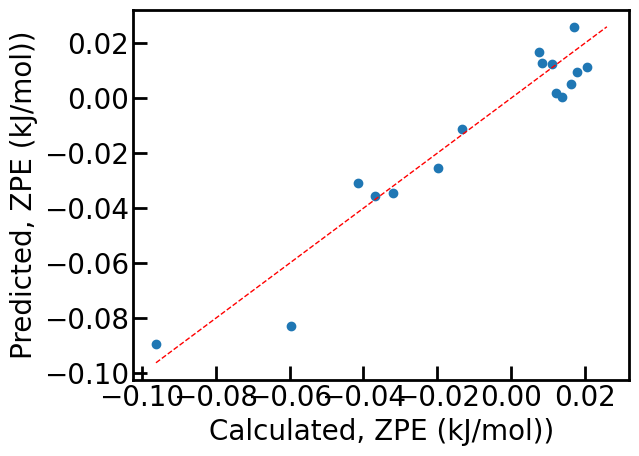

gpr1 0.9466848121370683
RMSE:  0.20265770161647528
RMSE unscaled:  0.007616063819324978
----------------------------------------


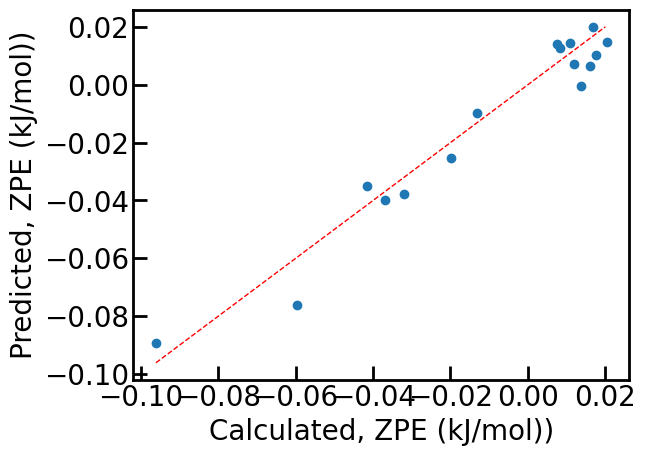

gpr2 0.9366203400646502
RMSE:  0.22095945666910605
RMSE unscaled:  0.0083038606973843
----------------------------------------


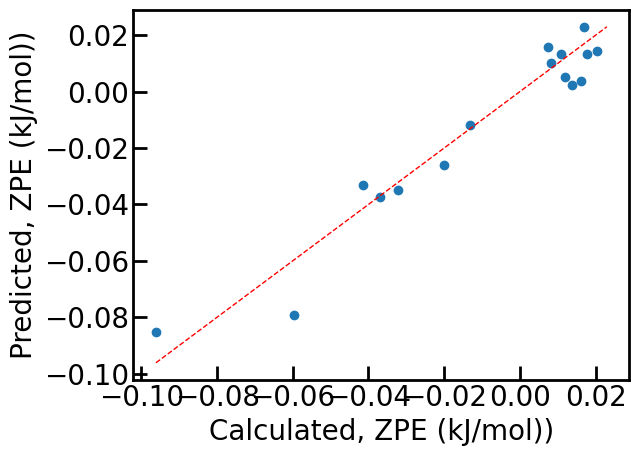

gpr3 0.9463830747610968
RMSE:  0.203230363279464
RMSE unscaled:  0.007637584974146206
----------------------------------------


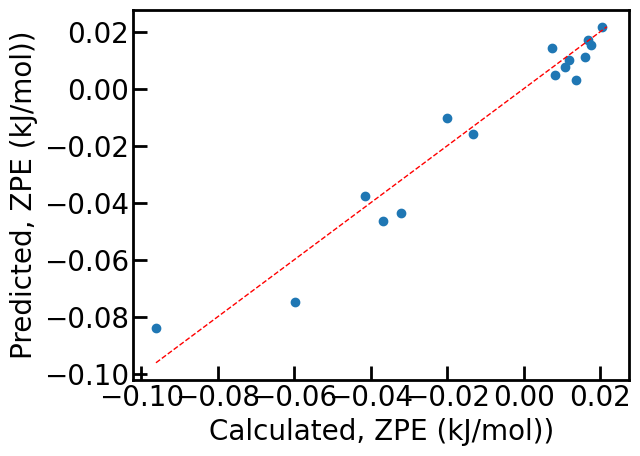

gpr4 0.9606593747002629
RMSE:  0.17408376477316306
RMSE unscaled:  0.006542228851138722
----------------------------------------


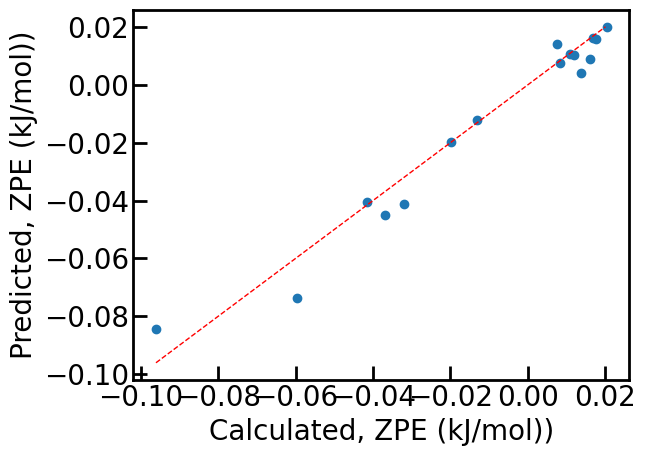

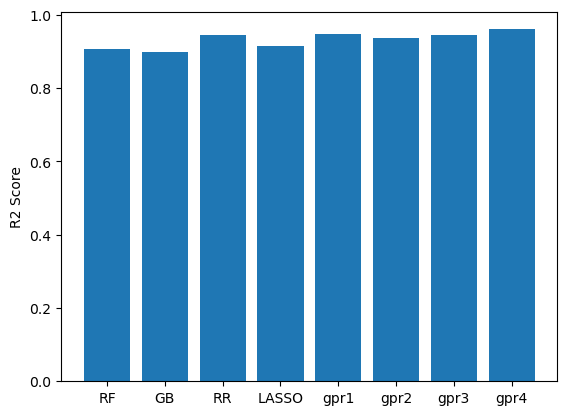

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8782914999706024
RMSE:  0.30619500099991154
RMSE unscaled:  0.011507091268541351
----------------------------------------


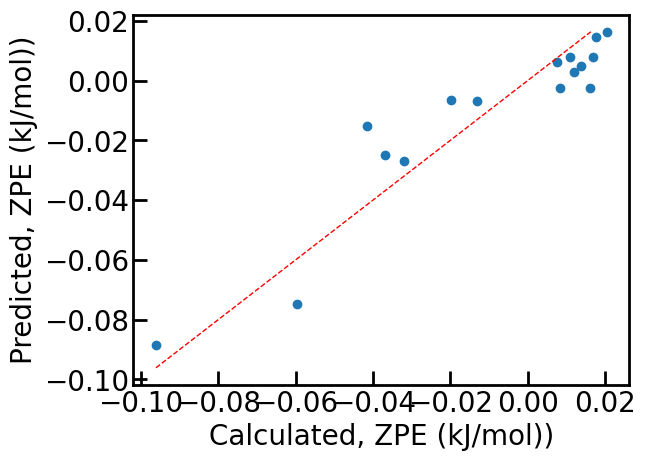

GB 0.789293120882022
RMSE:  0.4028811965723723
RMSE unscaled:  0.015140647901494568
----------------------------------------


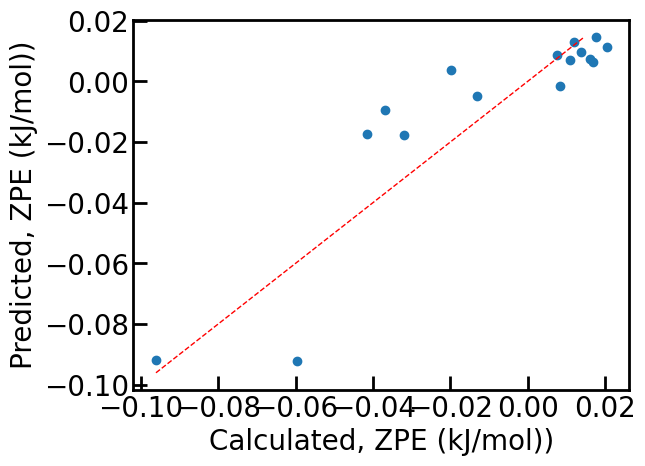

RR 0.7823426236645546
RMSE:  0.4094721189735587
RMSE unscaled:  0.015388340859794519
----------------------------------------


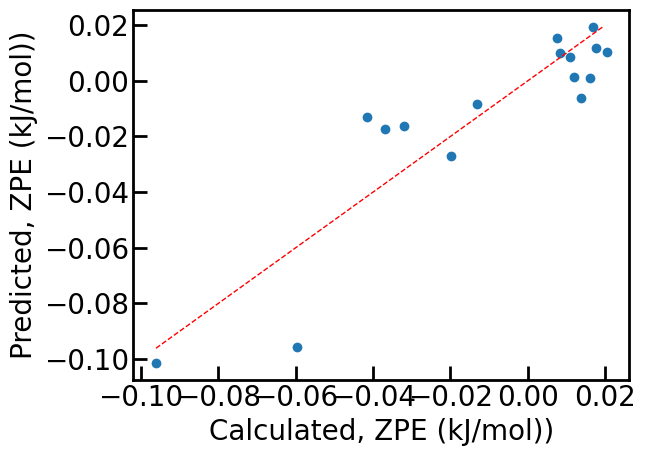

LASSO 0.8061722505640985
RMSE:  0.38640756252433595
RMSE unscaled:  0.014521553501206303
----------------------------------------


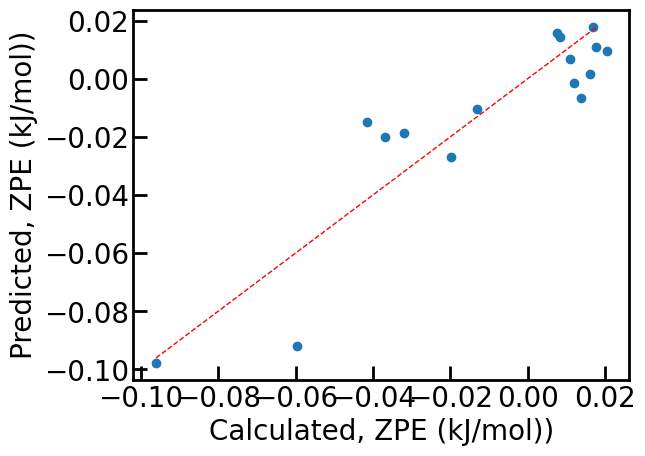

gpr1 0.7846592398450958
RMSE:  0.40728720033807503
RMSE unscaled:  0.015306229597132678
----------------------------------------


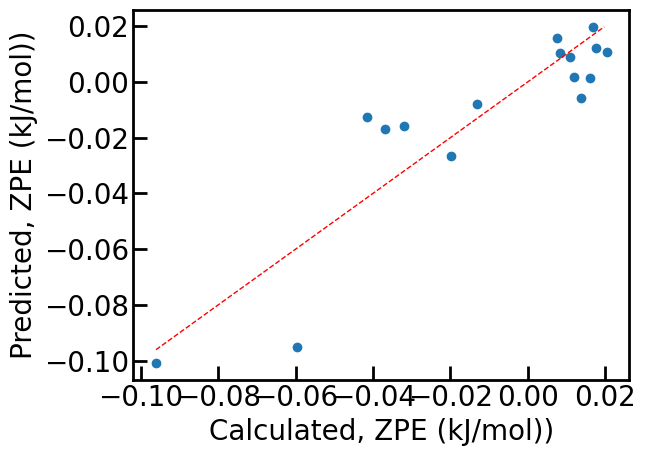

gpr2 0.8174146406910122
RMSE:  0.37503397778026665
RMSE unscaled:  0.014094123669650911
----------------------------------------


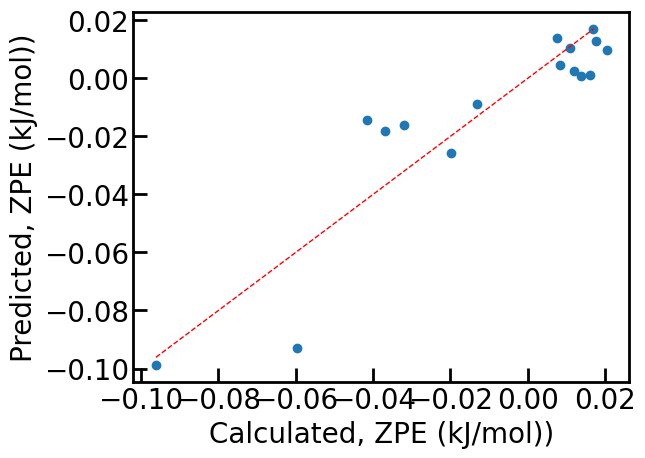

gpr3 0.8905479895006116
RMSE:  0.2903685077777056
RMSE unscaled:  0.010912317018882955
----------------------------------------


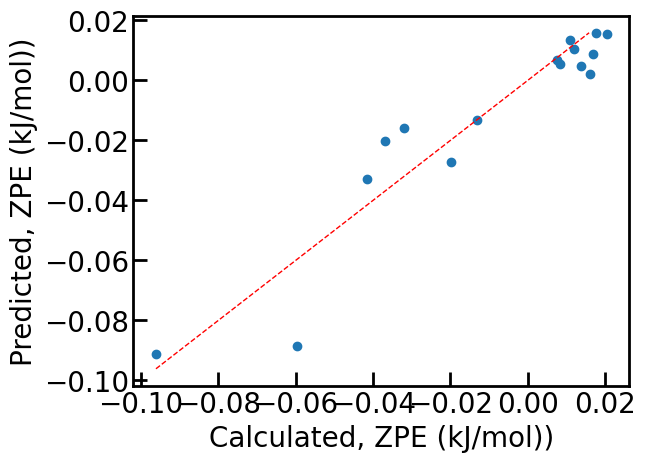

gpr4 0.8996307132039912
RMSE:  0.278059706537453
RMSE unscaled:  0.01044974088662937
----------------------------------------


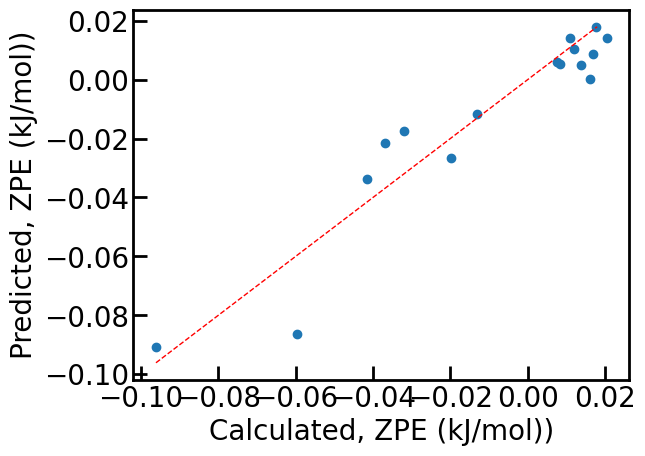

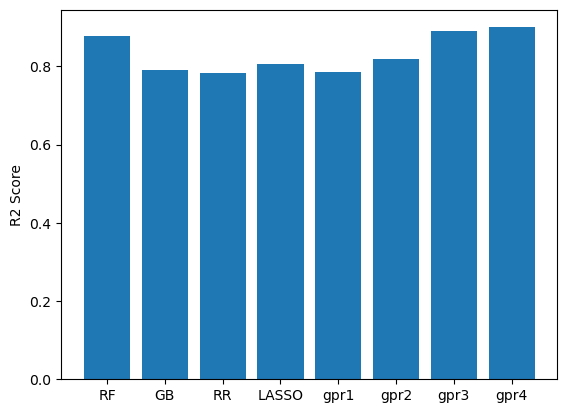

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9278623003657482
RMSE:  0.05713133159873242
RMSE unscaled:  0.00885903152775626
----------------------------------------


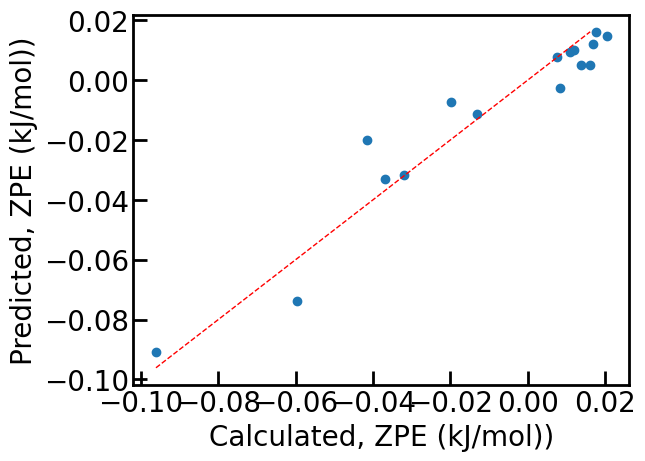

GB 0.9457163355116358
RMSE:  0.0495595986630864
RMSE unscaled:  0.007684925850196195
----------------------------------------


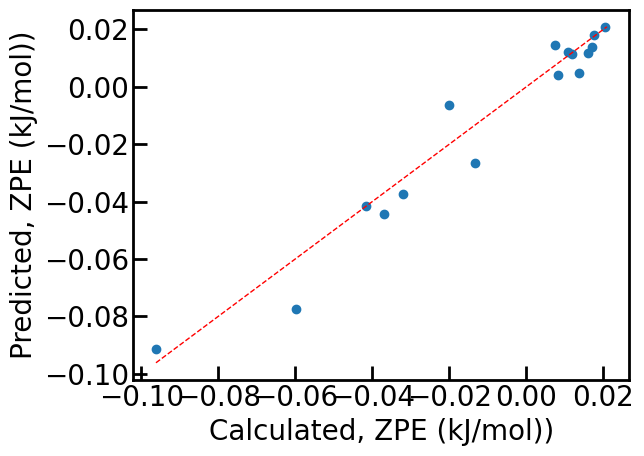

RR 0.9732192219563273
RMSE:  0.03481006201900793
RMSE unscaled:  0.005397798865874573
----------------------------------------


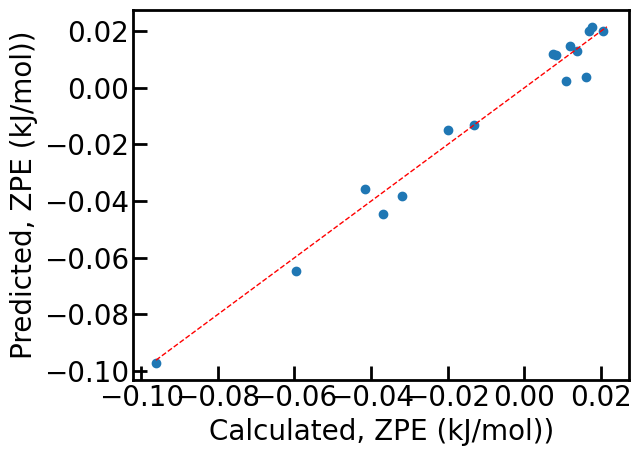

LASSO 0.6450465435648762
RMSE:  0.12672984589553504
RMSE unscaled:  0.019651278359511352
----------------------------------------


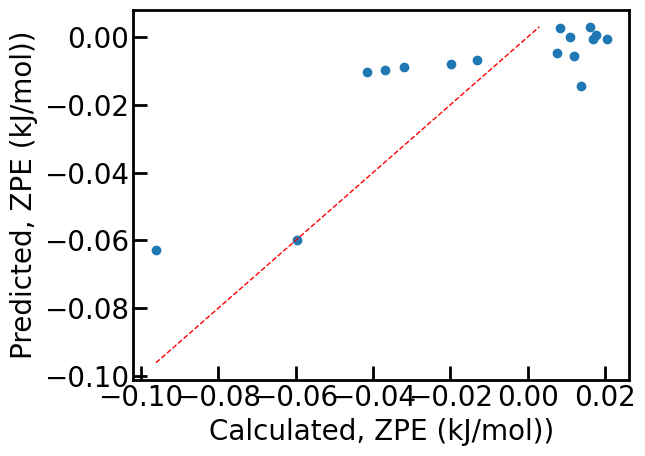

gpr1 0.9429640068642267
RMSE:  0.05080046715461928
RMSE unscaled:  0.007877340288660517
----------------------------------------


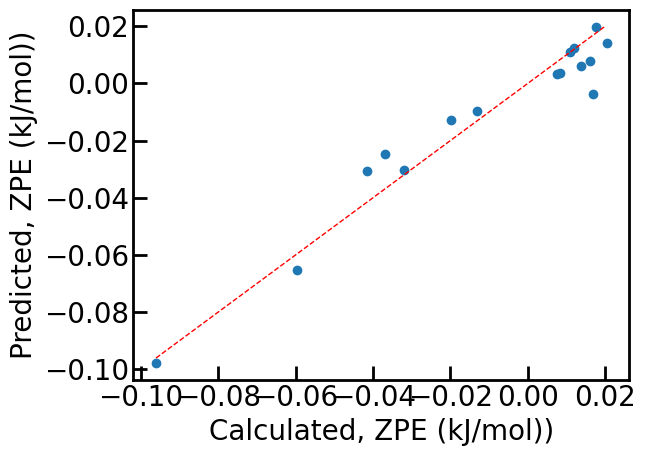

gpr2 -0.010738025659490447
RMSE:  0.2138516002505691
RMSE unscaled:  0.03316075463087849
----------------------------------------


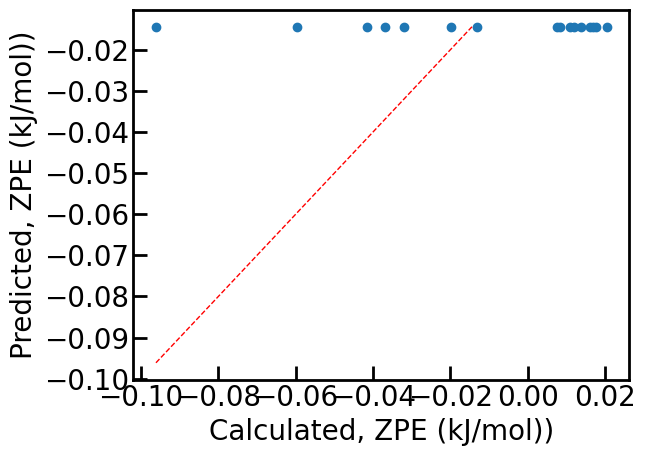

gpr3 0.9811854069714708
RMSE:  0.029176998719826458
RMSE unscaled:  0.004524311692220064
----------------------------------------


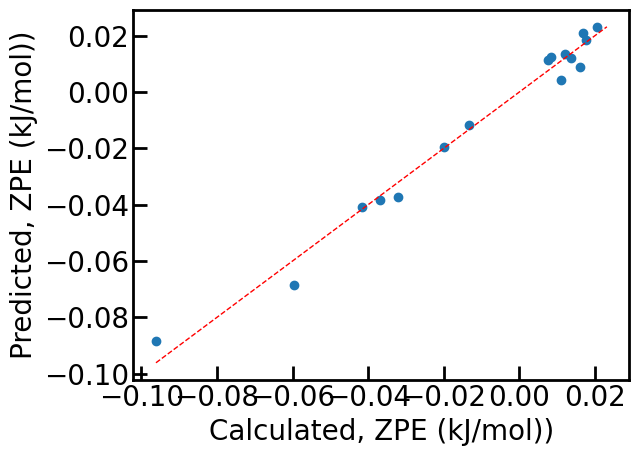

gpr4 0.9665804699837915
RMSE:  0.0388860088795924
RMSE unscaled:  0.006029832825751296
----------------------------------------


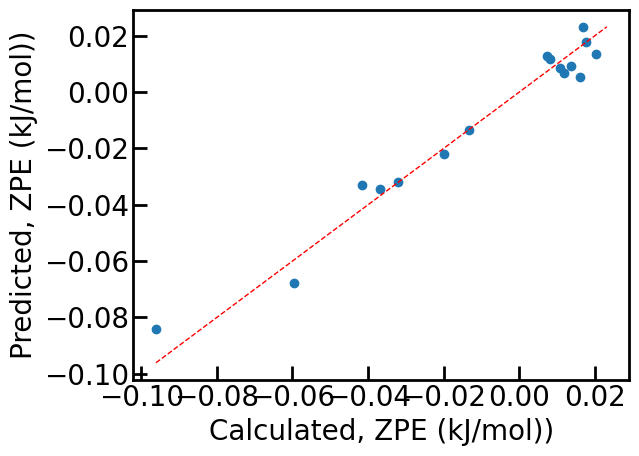

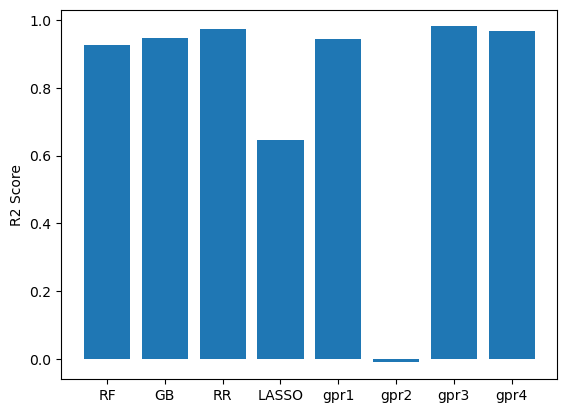

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  277.737710
2        s_X  224.504930
17       X_Z  180.497379
35      X_Ra  129.086980
7   mean_X2X  118.159584
5   mean_A2X   74.465968
1        s_B   40.154500
28      X_EA   37.557853
33    A_Rvdw   32.584372
12     E_coh   32.515523
32    X_ChiA   30.555031
45   X_Kappa   29.271831
0        s_A   25.107221
44   B_Kappa   24.034137
20     A_IEI   19.266747
22     X_IEI   15.954796
27      B_EA   15.195064
41      X_MV   14.461649
9    std_A2X   11.506073
31    A_ChiA   10.073841
15       A_Z    9.312288
29    A_ChiP    8.660578
37      A_BP    7.927719
25    X_IEII    7.574441
43   A_Kappa    7.450991
10   std_B2X    7.056630
16       B_Z    6.873299
30    B_ChiP    6.817450
39     B_Rho    5.873219
36      B_MP    5.617228


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA', 'A_Z',
       'A_ChiP', 'A_BP', 'X_IEII', 'A_Kappa', 'std_B2X', 'B_Z', 'B_ChiP',
       'B_Rho', 'B_MP', 'A_CvM', 'B_IEI', 'A_EA', 'B_Hf', 'density',
       'A_B', 'TF', 'OF', 'A_G', 'B_MV'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9375226454317277
RMSE:  0.05316851346929155
RMSE unscaled:  0.008244539798523406
----------------------------------------


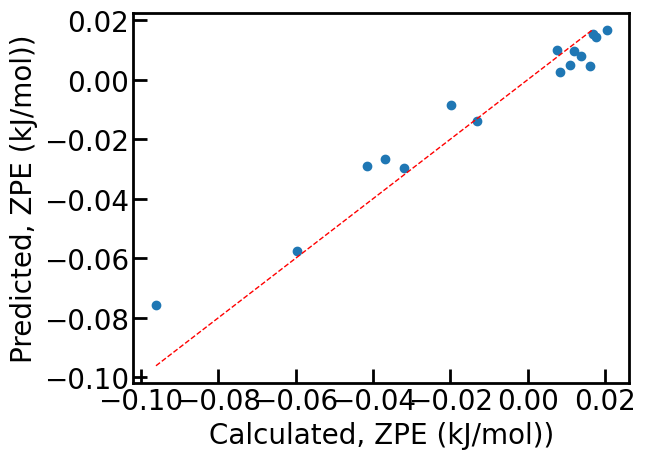

GB 0.8846538883161672
RMSE:  0.07224281853141516
RMSE unscaled:  0.011202284090258821
----------------------------------------


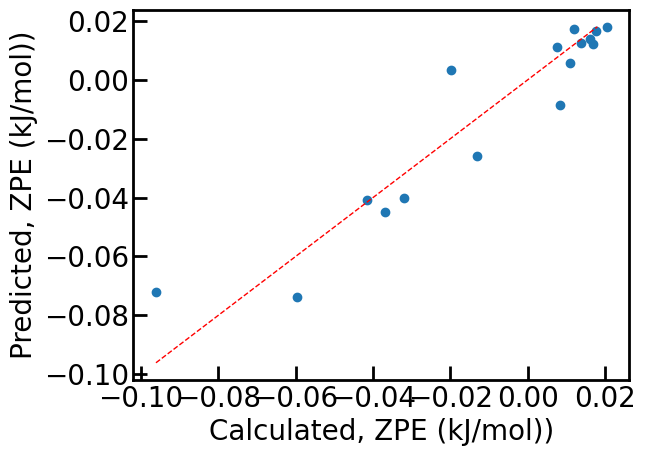

RR 0.9814683081910418
RMSE:  0.02895681133347517
RMSE unscaled:  0.004490168483176717
----------------------------------------


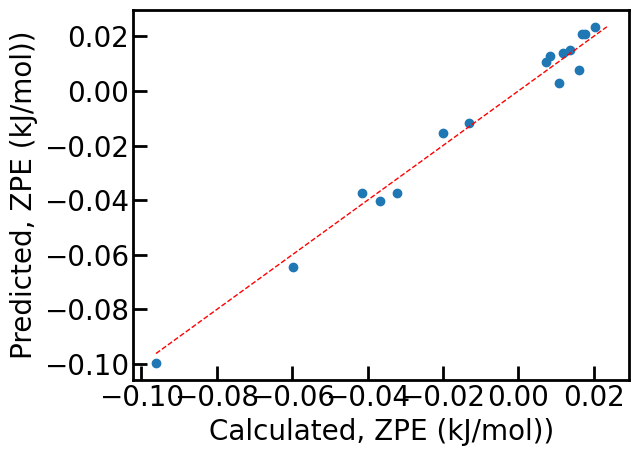

LASSO 0.6451042308978165
RMSE:  0.12671954735675373
RMSE unscaled:  0.01964968142351843
----------------------------------------


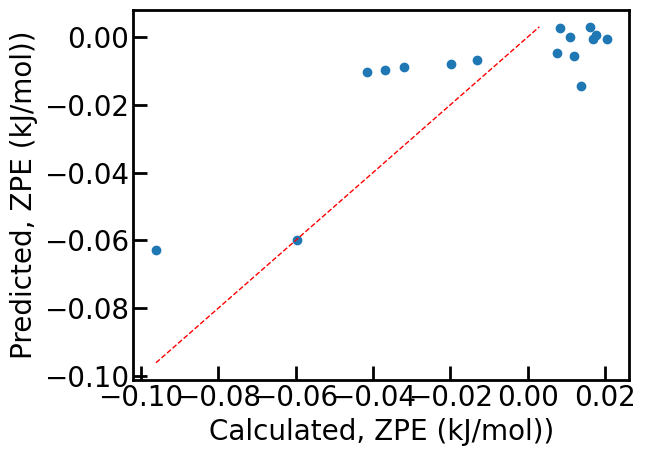

gpr1 0.9675437897939808
RMSE:  0.038321465198026775
RMSE unscaled:  0.005942292239284439
----------------------------------------


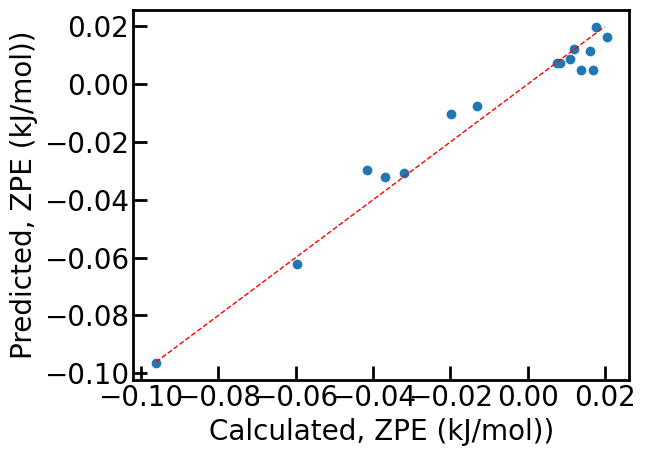

gpr2 -0.010738027833576469
RMSE:  0.21385160048056528
RMSE unscaled:  0.03316075466654269
----------------------------------------


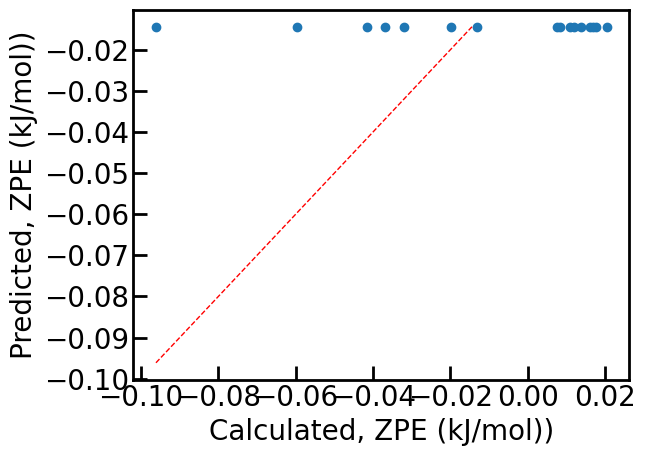

gpr3 0.9789281154866872
RMSE:  0.03087769625304139
RMSE unscaled:  0.00478802921191223
----------------------------------------


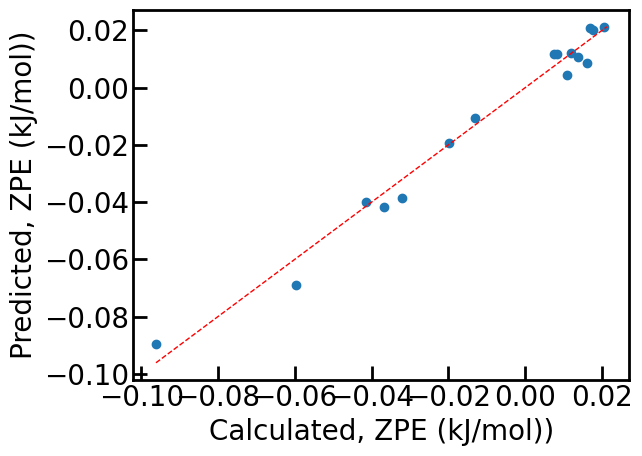

gpr4 0.9680390390171003
RMSE:  0.03802796770817744
RMSE unscaled:  0.005896781248324966
----------------------------------------


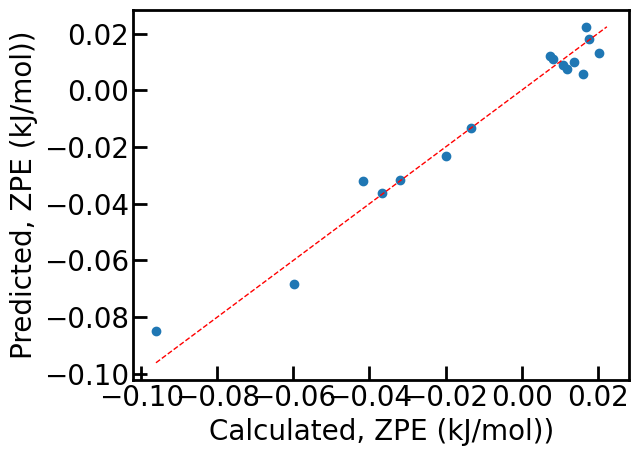

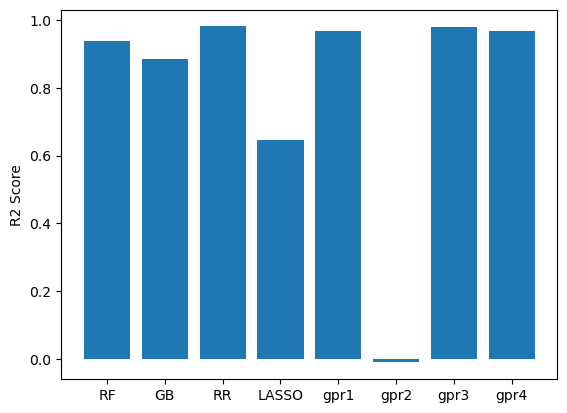

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA', 'A_Z',
       'A_ChiP', 'A_BP', 'X_IEII', 'A_Kappa', 'std_B2X', 'B_Z', 'B_ChiP',
       'B_Rho', 'B_MP'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9037102323111508
RMSE:  0.06600597817137327
RMSE unscaled:  0.010235172632551791
----------------------------------------


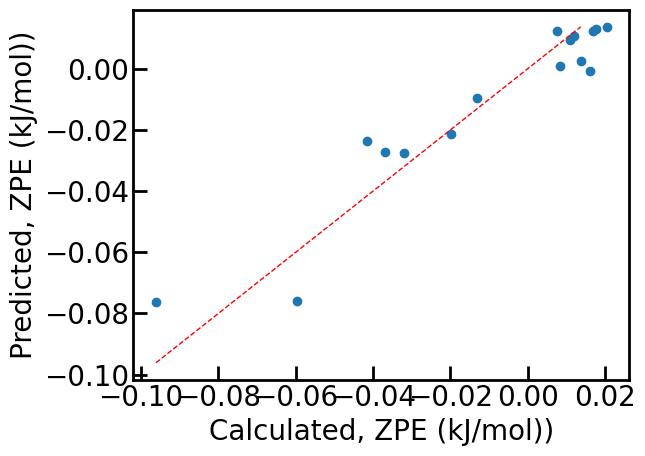

GB 0.857660784760647
RMSE:  0.080251929974744
RMSE unscaled:  0.012444211572084536
----------------------------------------


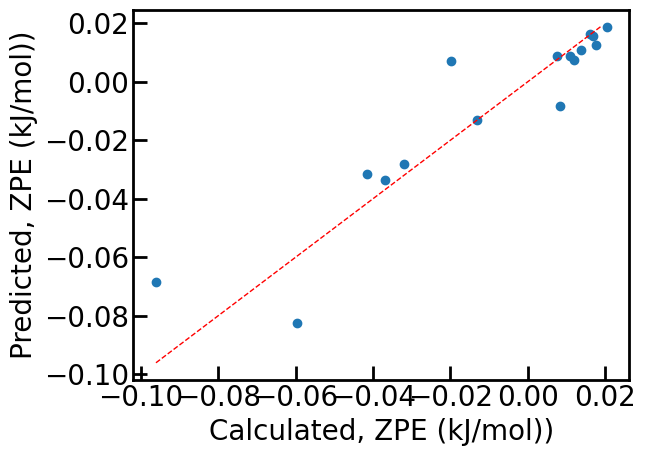

RR 0.9871592310188704
RMSE:  0.02410397777896884
RMSE unscaled:  0.0037376671103699433
----------------------------------------


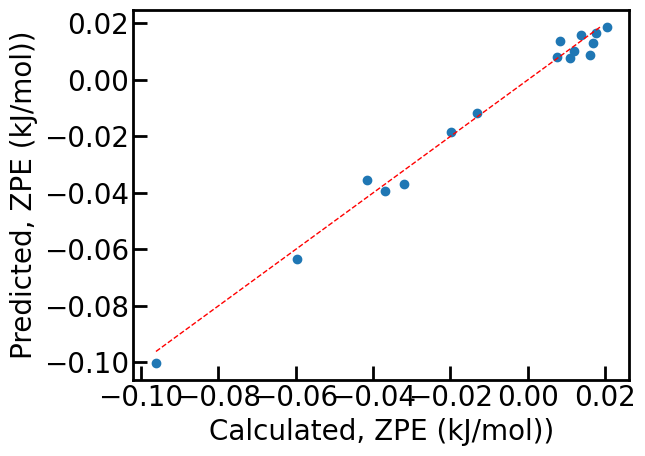

LASSO 0.6451042308978165
RMSE:  0.12671954735675373
RMSE unscaled:  0.01964968142351843
----------------------------------------


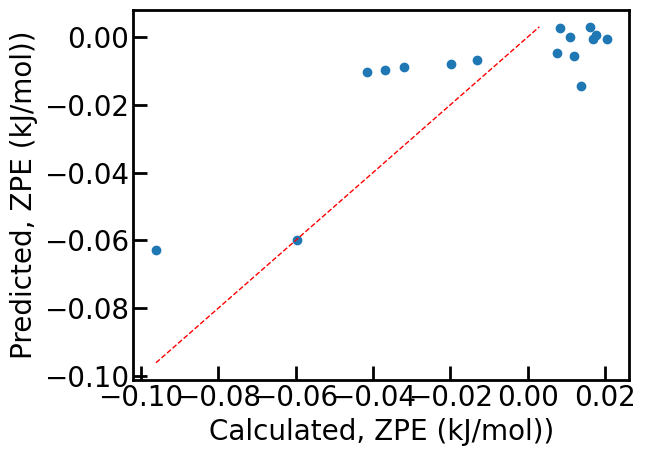

gpr1 0.9664653594497418
RMSE:  0.0389529209728229
RMSE unscaled:  0.006040208504506354
----------------------------------------


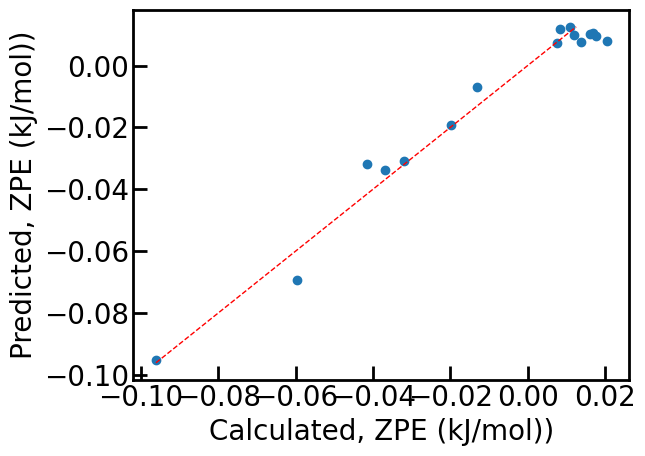

gpr2 -0.010738026236821296
RMSE:  0.21385160031164482
RMSE unscaled:  0.03316075464034915
----------------------------------------


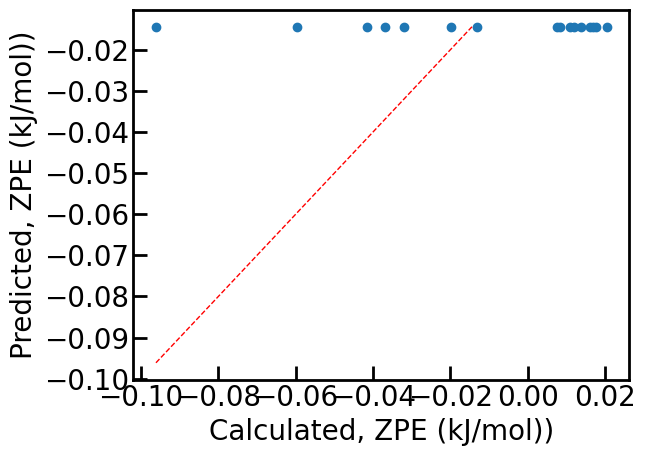

gpr3 0.9794971042321962
RMSE:  0.030457959433065344
RMSE unscaled:  0.004722943004091188
----------------------------------------


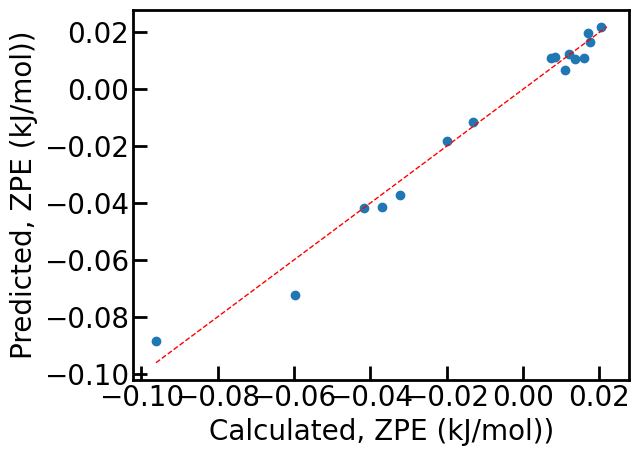

gpr4 0.9686986300668268
RMSE:  0.03763352288113004
RMSE unscaled:  0.005835616926384835
----------------------------------------


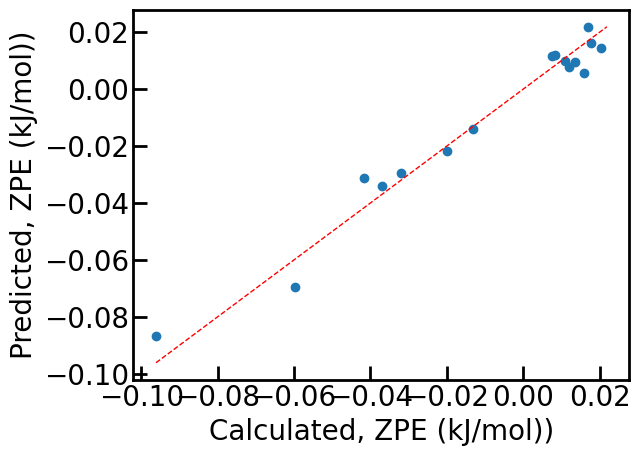

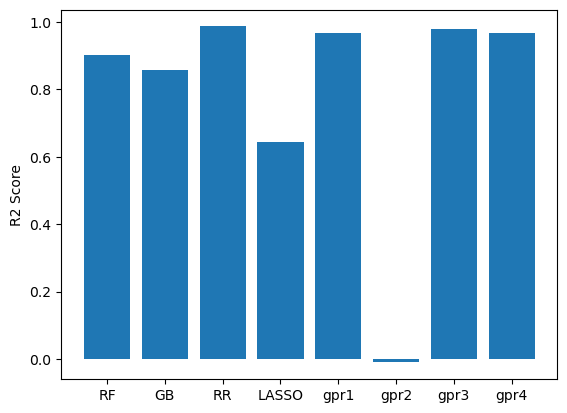

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh', 'X_ChiA', 'X_Kappa', 's_A', 'B_Kappa',
       'A_IEI', 'X_IEI', 'B_EA', 'X_MV', 'std_A2X', 'A_ChiA'],
      dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.915685992540672
RMSE:  0.061765088484196026
RMSE unscaled:  0.009577561924152454
----------------------------------------


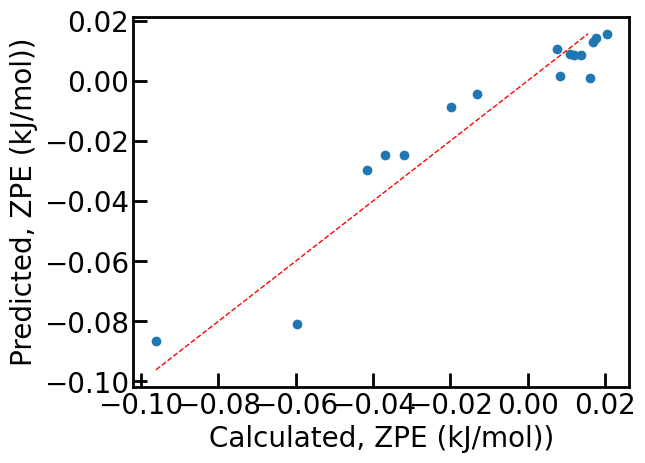

GB 0.9107144553547384
RMSE:  0.06355998383341402
RMSE unscaled:  0.009855886164858553
----------------------------------------


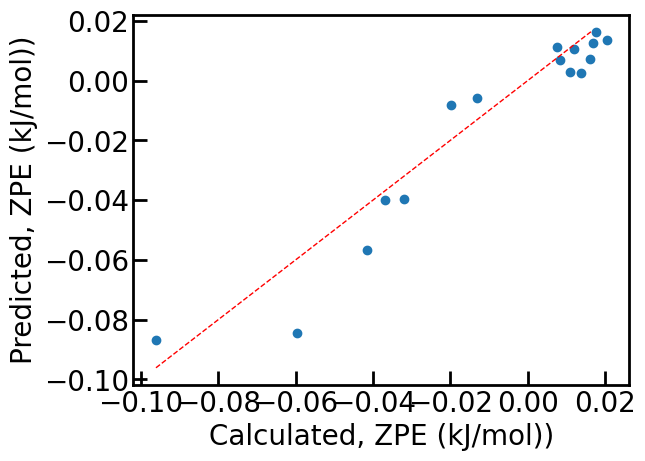

RR 0.9429872375037492
RMSE:  0.05079012063950241
RMSE unscaled:  0.007875735913249375
----------------------------------------


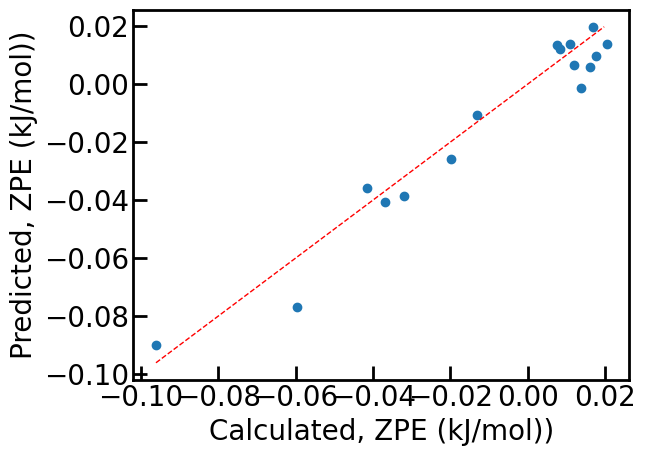

LASSO 0.6451042308978165
RMSE:  0.12671954735675373
RMSE unscaled:  0.01964968142351843
----------------------------------------


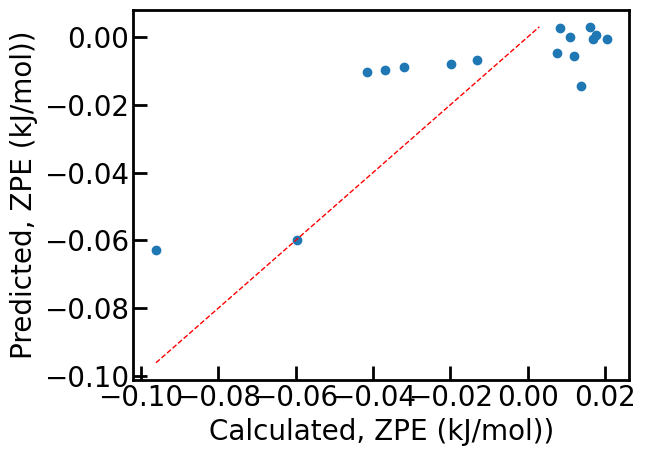

gpr1 0.9255522977486499
RMSE:  0.05803885701712018
RMSE unscaled:  0.008999756346673587
----------------------------------------


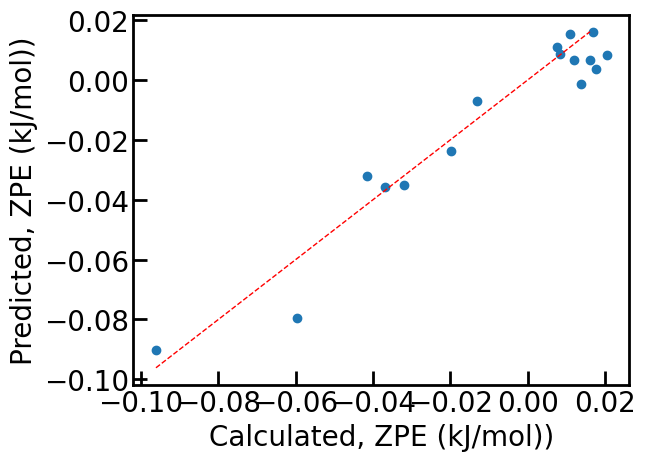

gpr2 -0.010738026357461905
RMSE:  0.21385160032440736
RMSE unscaled:  0.033160754642328163
----------------------------------------


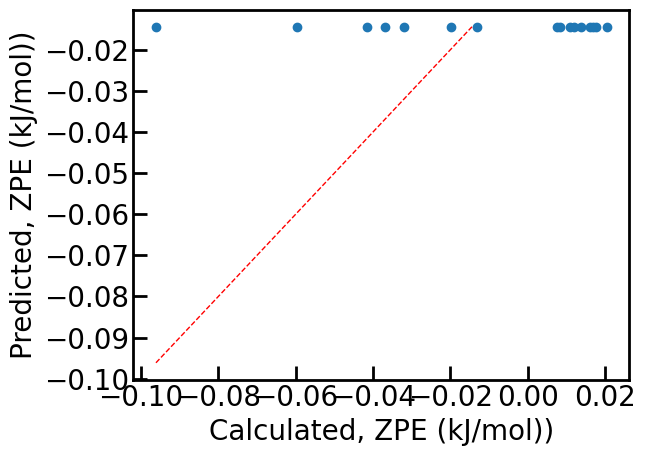

gpr3 0.9641275175506121
RMSE:  0.040287833896831916
RMSE unscaled:  0.006247205879671115
----------------------------------------


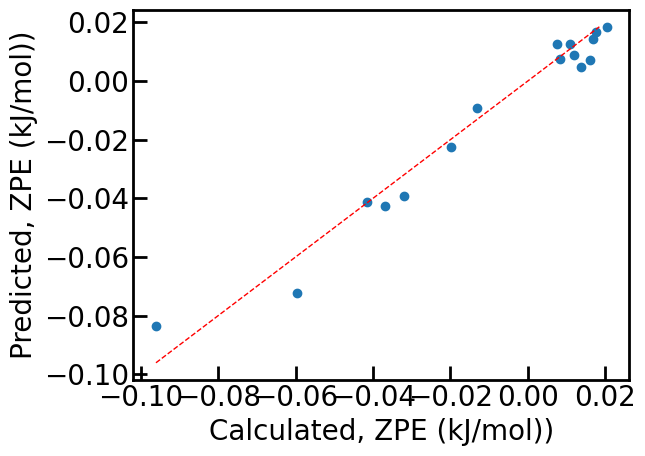

gpr4 0.9336188856876289
RMSE:  0.054804405522764395
RMSE unscaled:  0.00849820830006492
----------------------------------------


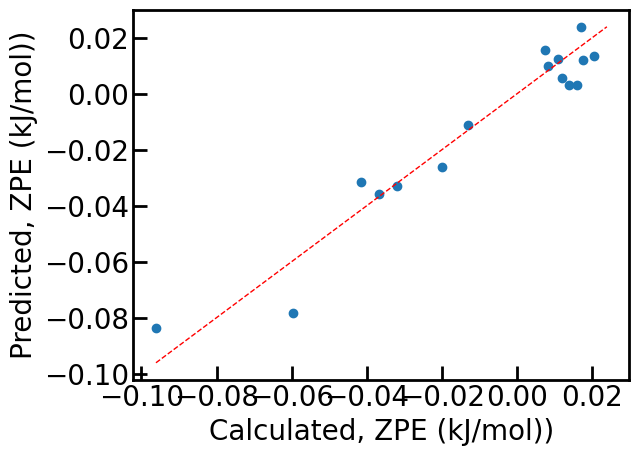

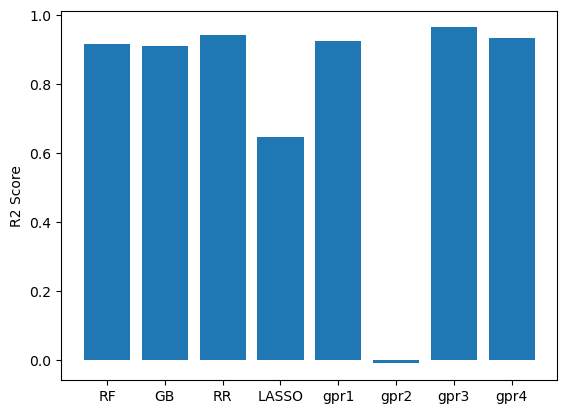

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 's_B',
       'X_EA', 'A_Rvdw', 'E_coh'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.9277947154726371
RMSE:  0.05715808814213196
RMSE unscaled:  0.008863180513171394
----------------------------------------


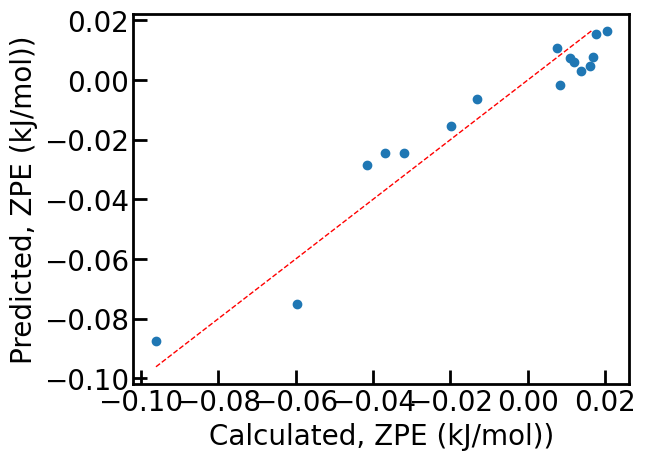

GB 0.8670936754926443
RMSE:  0.07754718295967256
RMSE unscaled:  0.012024801794461672
----------------------------------------


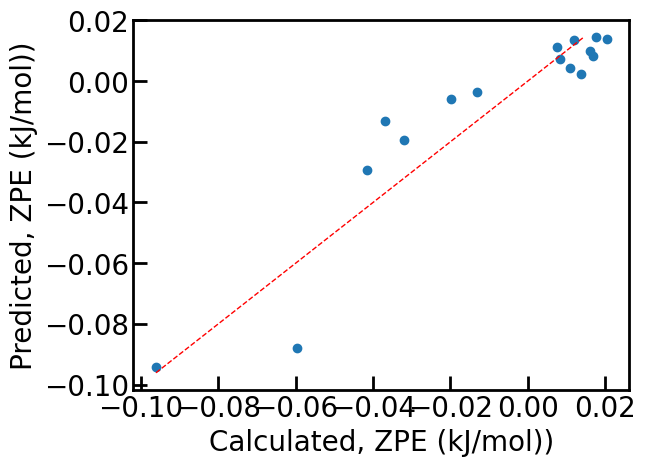

RR 0.7850809313046205
RMSE:  0.09861220661220706
RMSE unscaled:  0.015291235526156365
----------------------------------------


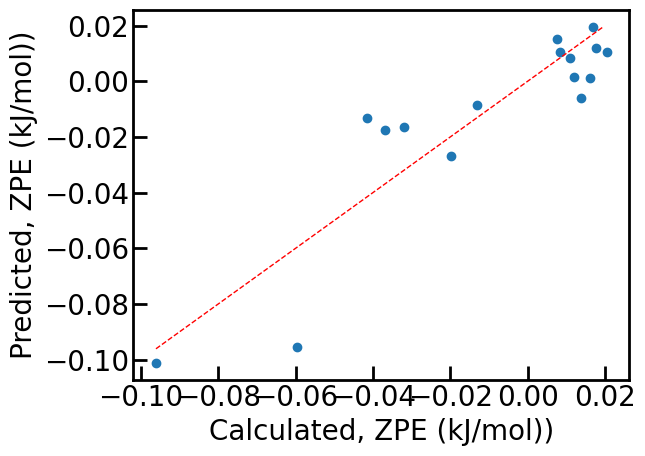

LASSO 0.6451042308978165
RMSE:  0.12671954735675373
RMSE unscaled:  0.01964968142351843
----------------------------------------


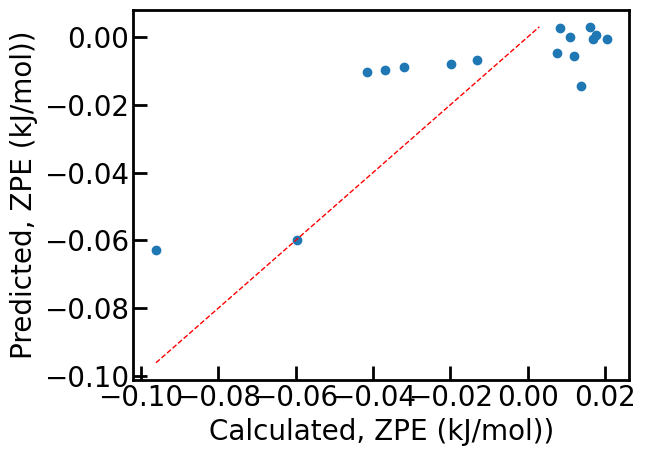

gpr1 0.7833923644173697
RMSE:  0.09899883475712436
RMSE unscaled:  0.015351187759536764
----------------------------------------


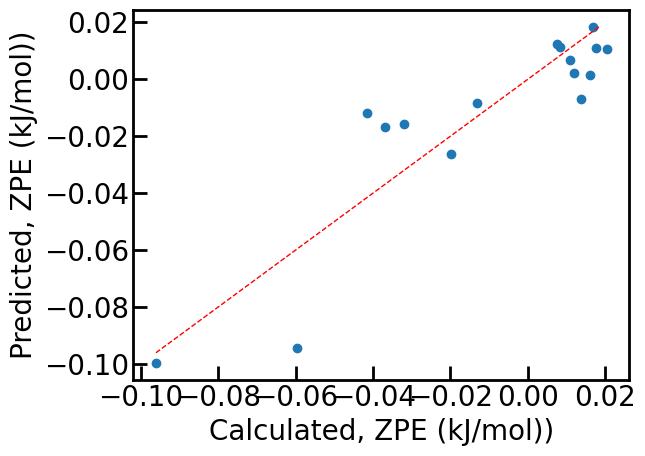

gpr2 -0.010738025957759856
RMSE:  0.21385160028212297
RMSE unscaled:  0.03316075463577137
----------------------------------------


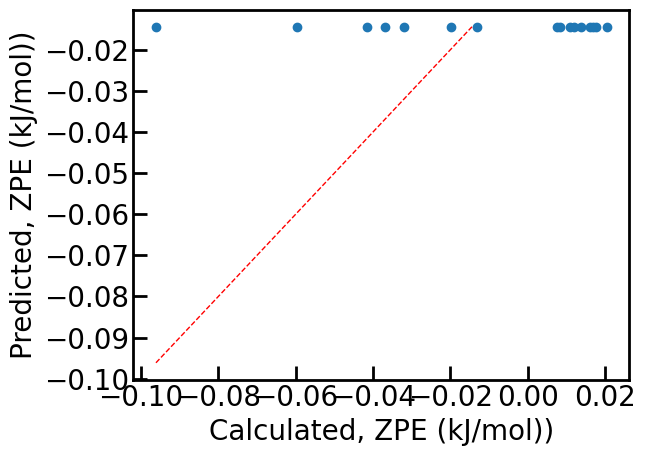

gpr3 0.8782921114159986
RMSE:  0.07420831425640577
RMSE unscaled:  0.011507062363547801
----------------------------------------


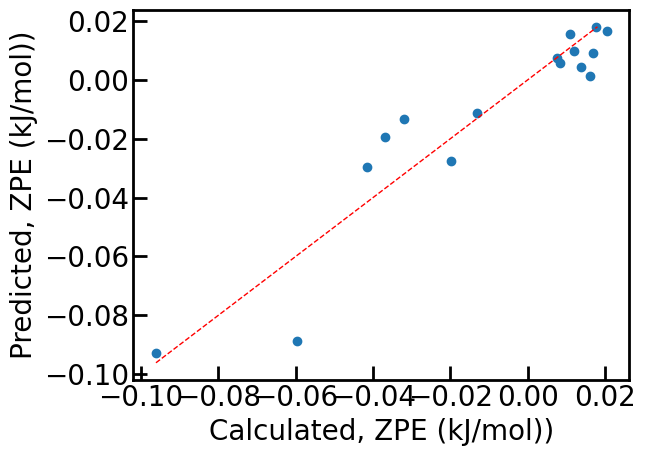

gpr4 0.8122044584953867
RMSE:  0.09217981680064616
RMSE unscaled:  0.014293801324207874
----------------------------------------


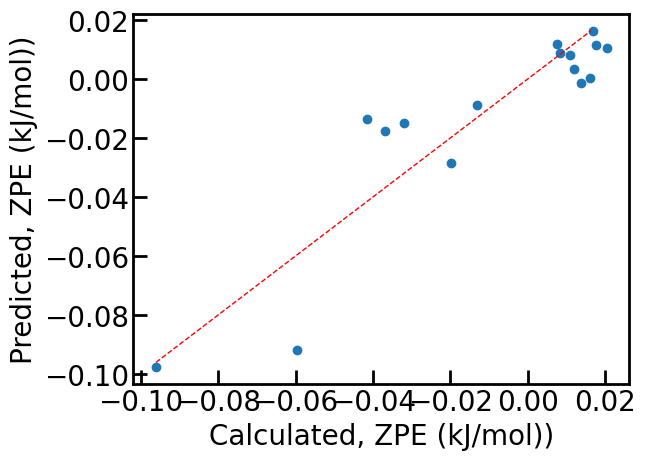

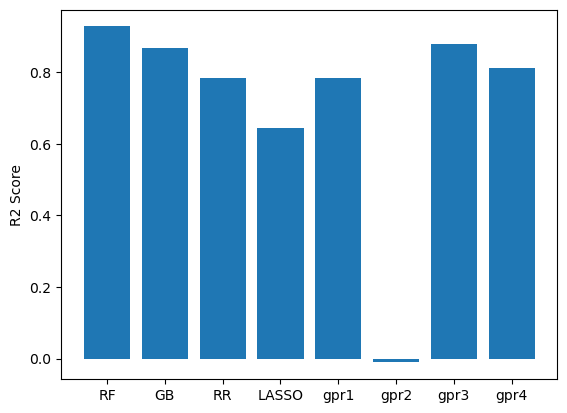

In [41]:
run_models()